### 🤖 Implement ReAct with LangGraph-What is ReAct?
ReAct (Reasoning + Acting) is a framework where an LLM:

- Reasons step-by-step (e.g. decomposes questions, makes decisions)

- Acts by calling tools like search, calculators, or retrievers

This makes it perfect for Agentic RAG:
✅ Think → Retrieve → Observe → Reflect → Final Answer

In [1]:
import os
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END
from langgraph.graph import StateGraph
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# --------------------------
# 1. Create Retriever Tool
# --------------------------

# Load content from blog
docs = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [3]:
# Retriever by default returns 4 most relevant documents
retriever.invoke("what are autonomous agents")

[Document(id='e53435b5-354e-4144-afa0-6ea6ce11534f', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [4]:
# to check the content of the 4 retrieved documents

for i, doc in enumerate(retriever.invoke("what are autonomous agents")):
    print(f"\nCHUNK {i}:")
    print(doc.page_content[:300])  # show the first 300 chars


CHUNK 0:
Or
@article{weng2023agent,
  title   = "LLM-powered Autonomous Agents",
  author  = "Weng, Lilian",
  journal = "lilianweng.github.io",
  year    = "2023",
  month   = "Jun",
  url     = "https://lilianweng.github.io/posts/2023-06-23-agent/"
}
References#
[1] Wei et al. “Chain of thought prompting e

CHUNK 1:
Boiko et al. (2023) also looked into LLM-empowered agents for scientific discovery, to handle autonomous design, planning, and performance of complex scientific experiments. This agent can use tools to browse the Internet, read documentation, execute code, call robotics experimentation APIs and leve

CHUNK 2:
Citation#
Cited as:

Weng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. https://lilianweng.github.io/posts/2023-06-23-agent/.

CHUNK 3:
LLM Powered Autonomous Agents | Lil'Log







































Lil'Log

















|






Posts




Archive




Search




Tags




FAQ









      LLM Powered Autonomous Agents
    
Date: J

**To make the retriever that we just created into a `tool` that a LLM can use we write the following function in the cell below,**

In [5]:
def retriever_tool_func(query: str) -> str:
    print("📚 Using RAGRetriever tool")
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [6]:
retriever_tool_func("what are autonomous agents")

📚 Using RAGRetriever tool


'Or\n@article{weng2023agent,\n  title   = "LLM-powered Autonomous Agents",\n  author  = "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Jun",\n  url     = "https://lilianweng.github.io/posts/2023-06-23-agent/"\n}\nReferences#\n[1] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022\n[2] Yao et al. “Tree of Thoughts: Dliberate Problem Solving with Large Language Models.” arXiv preprint arXiv:2305.10601 (2023).\nBoiko et al. (2023) also looked into LLM-empowered agents for scientific discovery, to handle autonomous design, planning, and performance of complex scientific experiments. This agent can use tools to browse the Internet, read documentation, execute code, call robotics experimentation APIs and leverage other LLMs.\nFor example, when requested to "develop a novel anticancer drug", the model came up with the following reasoning steps:\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered

In [7]:
@tool
def RAGRetriever(query: str):
    """Use this tool to fetch relevant knowledge base info."""
    return retriever_tool_func(query)

In [8]:
# Wikipedia tool
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Coding\\AgenticAIWorkspace\\venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

In [9]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")

C:\Users\joabd\AppData\Local\Temp\ipykernel_1788\4061363526.py:8: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_node=create_react_agent(llm,tools)


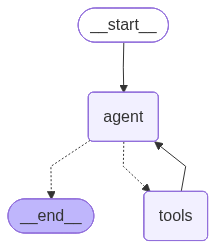

In [10]:
# ----------------------------
# 2. Define the Agent Node
# ----------------------------

tools = [RAGRetriever, wiki_tool]

## create the native Langgraph react agent
react_node=create_react_agent(llm,tools)
react_node

**Note:** The `react_node` was created easily using `create_react_agent`. 
- It just takes in the llm and the tools associated with it to form the diagram seen in the cell above.
- Now we have to integrate it to our `StateGraph` so that our entire graph works properly. 
- The entire diagram in the cell above is fitted into the `react_agent` node. So the `react_agent` node in our `StateGraph` when expanded will look like the diagram in the cell above. 
- Thus we have made our `react_agent` in our `StateGraph` an Agent that that can `ACT`, `OBSERVE` and `REASON`.

In [11]:
# --------------------------
# 3. LangGraph Agent State
# --------------------------

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

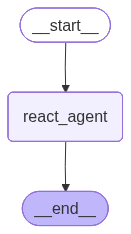

In [12]:
# --------------------------
# 4. Build LangGraph Graph
# --------------------------

builder = StateGraph(AgentState)

builder.add_node("react_agent", react_node)

builder.set_entry_point("react_agent")
builder.add_edge("react_agent", END)

graph = builder.compile()
graph

In [13]:
# --------------------------
# 5. Run the ReAct Agent
# --------------------------

if __name__ == "__main__":
    user_query = "What is an agent loop and how does Wikipedia describe autonomous agents?"
    state = {"messages": [HumanMessage(content=user_query)]}
    result = graph.invoke(state)

    print("\n✅ Final Answer:\n", result["messages"][-1].content)

📚 Using RAGRetriever tool

✅ Final Answer:
 ### Agent Loop
An agent loop refers to the process iterated by AI systems or agents to continuously improve their performance by utilizing feedback from their environment and updating their internal models or strategies. This iterative process allows agents, especially those driven by machine learning, to enhance their ability to perform tasks autonomously over time. The loop typically involves perceiving the environment, taking actions based on current knowledge, receiving feedback, and adjusting future actions to improve outcomes.

### Autonomous Agents (as described by Wikipedia)
According to Wikipedia, an autonomous agent is an artificial intelligence (AI) system capable of performing complex tasks independently. Autonomous or intelligent agents perceive their environment and take autonomous actions to achieve specific goals. They can improve their performance using machine learning or by acquiring knowledge.

Intelligent agents, a subset

**Warning:** Sometimes it can be noted that unless the LLM is prompted correctly using `system_prompt` and other `prompts`. Sometimes without the correct prompts the LLM says that it does not know the answer even when the answer is clearly in the vector database, which can be accessed using the `retriever tool` binded to the LLM.

In [19]:
if __name__ == "__main__":
    user_query = "What is Tree of Thoughts and what is Reflexion?"
    state = {"messages": [HumanMessage(content=user_query)]}
    result = graph.invoke(state)

    print("\n✅ Final Answer:\n", result["messages"][-1].content)

📚 Using RAGRetriever tool
📚 Using RAGRetriever tool

✅ Final Answer:
 **Tree of Thoughts**:

Tree of Thoughts, as proposed by Yao et al. in 2023, extends the concept of Chain of Thought (CoT) by exploring multiple reasoning possibilities at each step of a problem-solving process. Instead of a linear path of reasoning, Tree of Thoughts decomposes a problem into multiple thought steps and generates various potential thoughts at each step, creating a branching tree structure. This structure can be navigated using either a breadth-first search (BFS) or depth-first search (DFS), with each state being evaluated via a classifier or a majority vote. The approach enhances model performance on complex tasks by allowing for step-by-step thinking and decomposition of large tasks into smaller, manageable ones.

**Reflexion**:

Reflexion, introduced by Shinn & Labash in 2023, is a framework designed to enhance agents with dynamic memory and self-reflection capabilities to refine their reasoning skil

In [18]:
if __name__ == "__main__":
    user_query = "What is Tree of Thoughts and what is machine learning, use the tools you have ?"
    state = {"messages": [HumanMessage(content=user_query)]}
    result = graph.invoke(state)

    print("\n✅ Final Answer:\n", result["messages"][-1].content)

📚 Using RAGRetriever tool

✅ Final Answer:
 **Tree of Thoughts**:

- "Tree of Thoughts" is a concept from Yao et al. (2023) that extends the "Chain of Thought" (CoT) methodology by exploring multiple reasoning possibilities at each step. It involves decomposing a problem into multiple thought steps, generating multiple thoughts per step, and creating a tree structure to explore different paths. The search process can be conducted using BFS (Breadth-First Search) or DFS (Depth-First Search), with each state being evaluated by a classifier or majority vote.

- "Chain of Thought" is a prompting technique that enhances model performance on complex tasks by instructing models to "think step by step," thereby decomposing hard tasks into smaller, manageable steps. This approach provides insights into the model's reasoning process.

**Machine Learning**:

- Machine learning (ML) is a field of artificial intelligence focused on developing statistical algorithms that can learn from data and gene

### Tool creation for RAG agents with langgraph 
To create tools for RAG agents using LangGraph, you're essentially building LLM-invocable functions that your agent can call as part of its reasoning + acting loop (ReAct).

LangGraph uses the Tool abstraction from LangChain and fully supports tools for:

- RAG retrieval
- Search
- Wikipedia
- SQL
- Web APIs
- Calculators, etc.

#### ✅ Tool Design Requirements
A LangGraph tool must:

- Have a name
- Have a description (used by the LLM to decide when to use it)
- Have a callable func, accepting a single input (usually str) and returning str

In [45]:
import os
from typing import Annotated, Sequence, TypedDict
from langchain_core.tools import tool
from langchain_core.tools import Tool
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_community.document_loaders import TextLoader

In [46]:
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001CF72776D80>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001CF72612210>, root_client=<openai.OpenAI object at 0x000001CF727764B0>, root_async_client=<openai.AsyncOpenAI object at 0x000001CF72611B50>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [47]:
# Generic function to create a retireval tool
def make_retriever_tool_from_text(file, name, desc):
    """Create a retrieval tool from a text file."""
    
    docs = TextLoader(file, encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(
        chunk_size=500, chunk_overlap=50
    ).split_documents(docs)

    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    retriever = vs.as_retriever()

    # function the tool will run
    def dynamic_retriever(query: str) -> str:
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)

    # Create a LangChain tool manually
    return Tool(
        name=name,
        description=desc,
        func=dynamic_retriever
    )



# Wikipedia tool
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tool

# Pubmed Tool
from langchain_community.tools.pubmed.tool import PubmedQueryRun
Pubmed = PubmedQueryRun()



In [48]:
internal_tool_1=make_retriever_tool_from_text(
    r"..\assets\sample_docs.txt",
    "InternalTechDocs",
    "Search internal tech documents for proprietary architecture and methods."
)
internal_tool_1

Tool(name='InternalTechDocs', description='Search internal tech documents for proprietary architecture and methods.', func=<function make_retriever_tool_from_text.<locals>.dynamic_retriever at 0x000001CF6EEEE7A0>)

In [49]:
internal_tool_2 = make_retriever_tool_from_text(
    r"..\assets\research_notes.txt",
    "InternalResearchNotes",
    "Search internal research notes for experimental results and agent designs."
)
internal_tool_2

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results and agent designs.', func=<function make_retriever_tool_from_text.<locals>.dynamic_retriever at 0x000001CFAC643880>)

C:\Users\joabd\AppData\Local\Temp\ipykernel_1788\2664181483.py:8: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_node = create_react_agent(llm, tools)


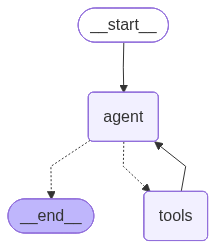

In [50]:
tools = [
    wiki_tool,
    Pubmed,
    internal_tool_1,
    internal_tool_2
]

react_node = create_react_agent(llm, tools)
react_node


In [51]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

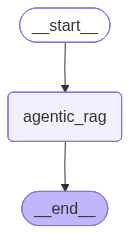

In [52]:
builder = StateGraph(AgentState)
builder.add_node("agentic_rag", react_node)
builder.set_entry_point("agentic_rag")
builder.add_edge("agentic_rag", END)

graph = builder.compile()
graph


In [59]:
query = "What do our internal research notes say about transformer variants, and what does papers about weight loss suggest, finally what is agenticAI?"

state = {"messages": [HumanMessage(content=query)]}
result = graph.invoke(state)

for msg in result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What do our internal research notes say about transformer variants, and what does papers about weight loss suggest, finally what is agenticAI?
================================== Ai Message ==================================
Tool Calls:
  InternalResearchNotes (call_iQOlboqdajOKZF1QOyE3BNbn)
 Call ID: call_iQOlboqdajOKZF1QOyE3BNbn
  Args:
    __arg1: transformer variants
  pub_med (call_27JJ37GIQFhlpqBy6sbJJ75X)
 Call ID: call_27JJ37GIQFhlpqBy6sbJJ75X
  Args:
    query: weight loss
  wikipedia (call_UTqbFBZowptqllFWsmAsN07Y)
 Call ID: call_UTqbFBZowptqllFWsmAsN07Y
  Args:
    query: AgenticAI
================================= Tool Message =================================
Name: InternalResearchNotes

Experiment Log: Transformer Evaluation - July 2024

EfficientFormer:
- Top-1 accuracy: 92.4% on TinyImageNet
- Peak memory usage: 290MB (batch size = 16)
- Deployment target: Raspberry Pi 4
- Notes: Works well